In [2]:
import pandas as pd
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
import zipfile
import os
from torch.utils.data import ConcatDataset
import numpy as np
import torch as torch

# Extra info for logging
extra = 'change to freeze all layers + dropout 0.5 + unfreeze batchnorm + cropped images + track both best val_loss and val_acc + add original image + test image not cropped + add augmented_more dataset + no crop augmented data'

# Load the metadata
metadata = pd.read_csv('meta_data.csv')
metadata['augmented_images_more'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_more')
metadata['augmented_image_nocrop_name'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_nocrop')

# Create a dictionary mapping from image file name to is_training_image

# Only add training images for augmented
temp = metadata[metadata.is_training_image == 1]

is_training_image = dict(zip(temp.augmented_image_name, temp.is_training_image))   # original augmentation
is_training_image.update(zip(temp.augmented_images_more, temp.is_training_image))  # more augmentation
is_training_image.update(zip(temp.augmented_image_nocrop_name, temp.is_training_image)) # augmented but no crop to bbox

# Add original data
# Test will be from original images (not cropped, only resize to 224,224)
is_training_image.update(zip(metadata.image_name, metadata.is_training_image))

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load or extract dataset
def load_or_extract(directory, zip_file):
    if os.path.isdir(directory):
        print(f"Directory {directory} exists, skipping zip extraction.")
    else:
        print(f"Directory {directory} does not exist, extracting zip file {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall("./")
        print(f"Extracted {zip_file}.")

# Load or extract both datasets
load_or_extract("../../augmented_images", "../../augmented_images.zip")
load_or_extract("../../CUB_200_2011/images", "../../CUB_200_2011/images.zip")
load_or_extract("../../augmented_images_more","../../augmented_images_more.zip")
load_or_extract("../../augmented_images_nocrop","../../augmented_images_nocrop.zip")

# Load datasets
dataset_augmented = ImageFolder("../../augmented_images", transform=transform)
dataset_images = ImageFolder("../../CUB_200_2011/images", transform=transform)
dataset_augmented_more = ImageFolder("../../augmented_images_more", transform=transform)
dataset_augmented_nocrop = ImageFolder("../../augmented_images_nocrop", transform=transform)


# Combine datasets
all_classes = sorted(set(dataset_images.classes + dataset_augmented.classes + dataset_augmented_more.classes + dataset_augmented_nocrop.classes))
combined_dataset = ConcatDataset([dataset_images, dataset_augmented, dataset_augmented_more, dataset_augmented_nocrop])
combined_dataset.classes = all_classes

print("Loading test indices...")
test_indices = np.load('./test_indices.npy')

# Create subset datasets
test_dataset = Subset(combined_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Test set size: ", len(test_dataset))

Directory ../../augmented_images exists, skipping zip extraction.
Directory ../../CUB_200_2011/images exists, skipping zip extraction.
Directory ../../augmented_images_more exists, skipping zip extraction.
Directory ../../augmented_images_nocrop exists, skipping zip extraction.
Loading test indices...
Test set size:  4634


In [3]:
MODEL1_PATH = './efficient_net/efficientnet_b0.pth'
MODEL2_PATH = './google_net/best model with normalising/googlenet_best_3.pth'
MODEL3_PATH = './mobile_net/mobilenet_best.pth'

In [4]:
import torch
from torch import nn
from torchvision.models import efficientnet_b0
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def training_step(self, batch):
        raise NotImplementedError

    def validation_step(self, batch):
        raise NotImplementedError

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

class EfficientNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = efficientnet_b0(pretrained=True)

        # Add custom layers
        self.network.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )


    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def freeze(self):
        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last layers
        for param in list(self.network.parameters())[0:-4]:
            param.requires_grad = True

    def unfreeze(self):
        # Unfreeze all parameters of the model
        for param in self.network.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
num_classes = len(combined_dataset.classes)
# model1 = torch.load(MODEL1_PATH, map_location=device)
# model1.eval()

Device:  cuda


In [5]:
from torchvision.models import mobilenet_v2
import torch.nn.functional as F

class MobileNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = mobilenet_v2(pretrained=True)

        # No freezing
        # for param in self.network.parameters():
        #     param.requires_grad = True

        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # # Unfreeze the last five layers
        # for param in list(self.network.parameters())[-5:]:
        #     param.requires_grad = True

        # Unfreeze Batch Normalization
        for module in self.network.modules():
            if isinstance(module, nn.BatchNorm2d):
                for param in module.parameters():
                    param.requires_grad = True

        # Unfreeze last layer
        for param in self.network.features[-1].parameters():
            param.requires_grad = True
                    
        # Replace the classifier with a custom one
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier = nn.Sequential(
            nn.Dropout(0.5), 
		    nn.Linear(num_ftrs, num_classes)
            )
        # self.network.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

In [6]:
from torchvision.models import googlenet
import torch.nn.functional as F

class GoogLeNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = googlenet(pretrained=True)

        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last five layers
        for param in list(self.network.parameters())[-4:]:
            param.requires_grad = True

        # Replace the classifier with a custom one
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
    def unfreeze_all(self):
        for param in self.network.parameters():
            param.requires_grad = True
    
    def freeze_all_except_custom(self):
        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last 4 layer
        list(self.network.parameters())[-4].requires_grad = True

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

In [7]:
model1 = torch.load(MODEL1_PATH, map_location=device)
model1 = model1.to(device)
model1.eval()
model2 = torch.load(MODEL2_PATH, map_location=device)
model2 = model2.to(device)
model2.eval()
model3 = MobileNetModel(num_classes)
model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
model3 = model3.to(device)
model3.eval()

c:\Users\wamik\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wamik\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetModel(
  (network): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [8]:
# Calculate loss and accuracy of model on test set
def test_model(model, test_loader, device):
    model = model.to(device)
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, 1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(preds == targets.data)
            total_samples += inputs.size(0)
    mean_loss = total_loss / total_samples
    accuracy = total_correct.double() / total_samples
    print("Loss: {:.4f}, Accuracy: {:.4f}".format(mean_loss, accuracy))

print("Testing model 1...")
test_model(model1, test_loader, device)
print("Testing model 2...")
test_model(model2, test_loader, device)
print("Testing model 3...")
test_model(model3, test_loader, device)

Testing model 1...
Loss: 0.5966, Accuracy: 0.9083
Testing model 2...
Loss: 0.7206, Accuracy: 0.8671
Testing model 3...
Loss: 0.6274, Accuracy: 0.8707


Generating classification report for model 1...


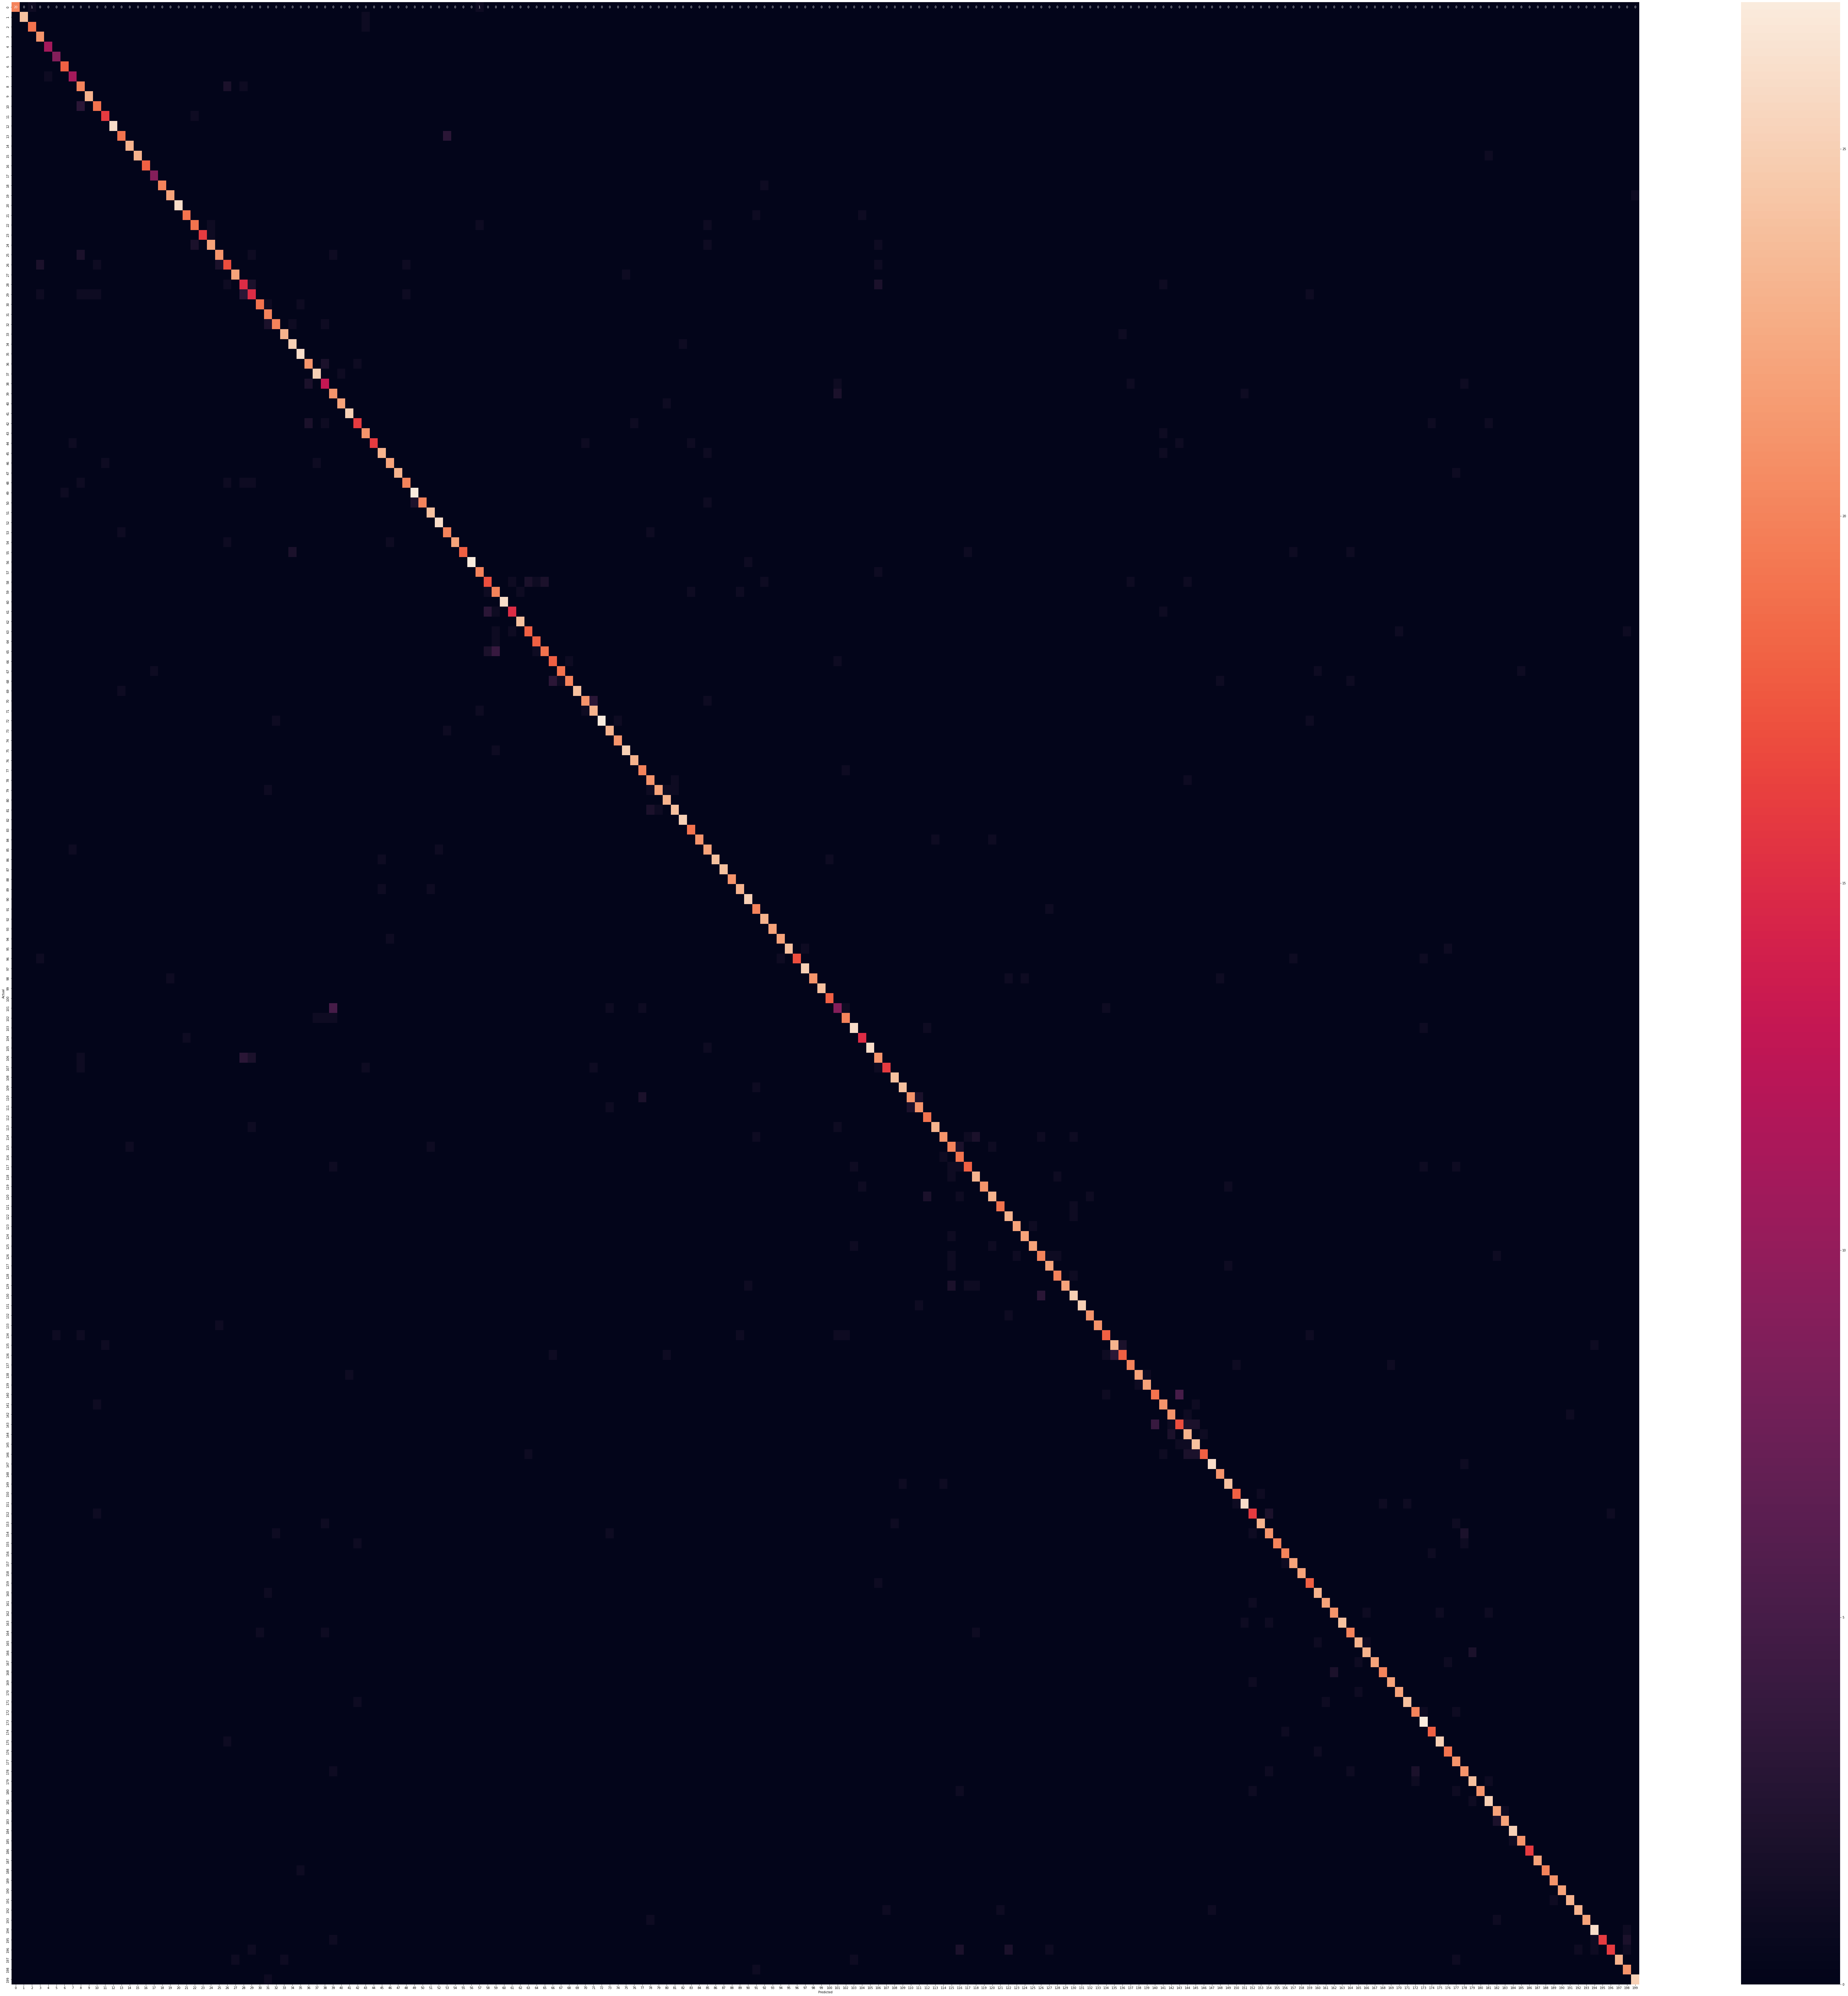

Generating classification report for model 2...


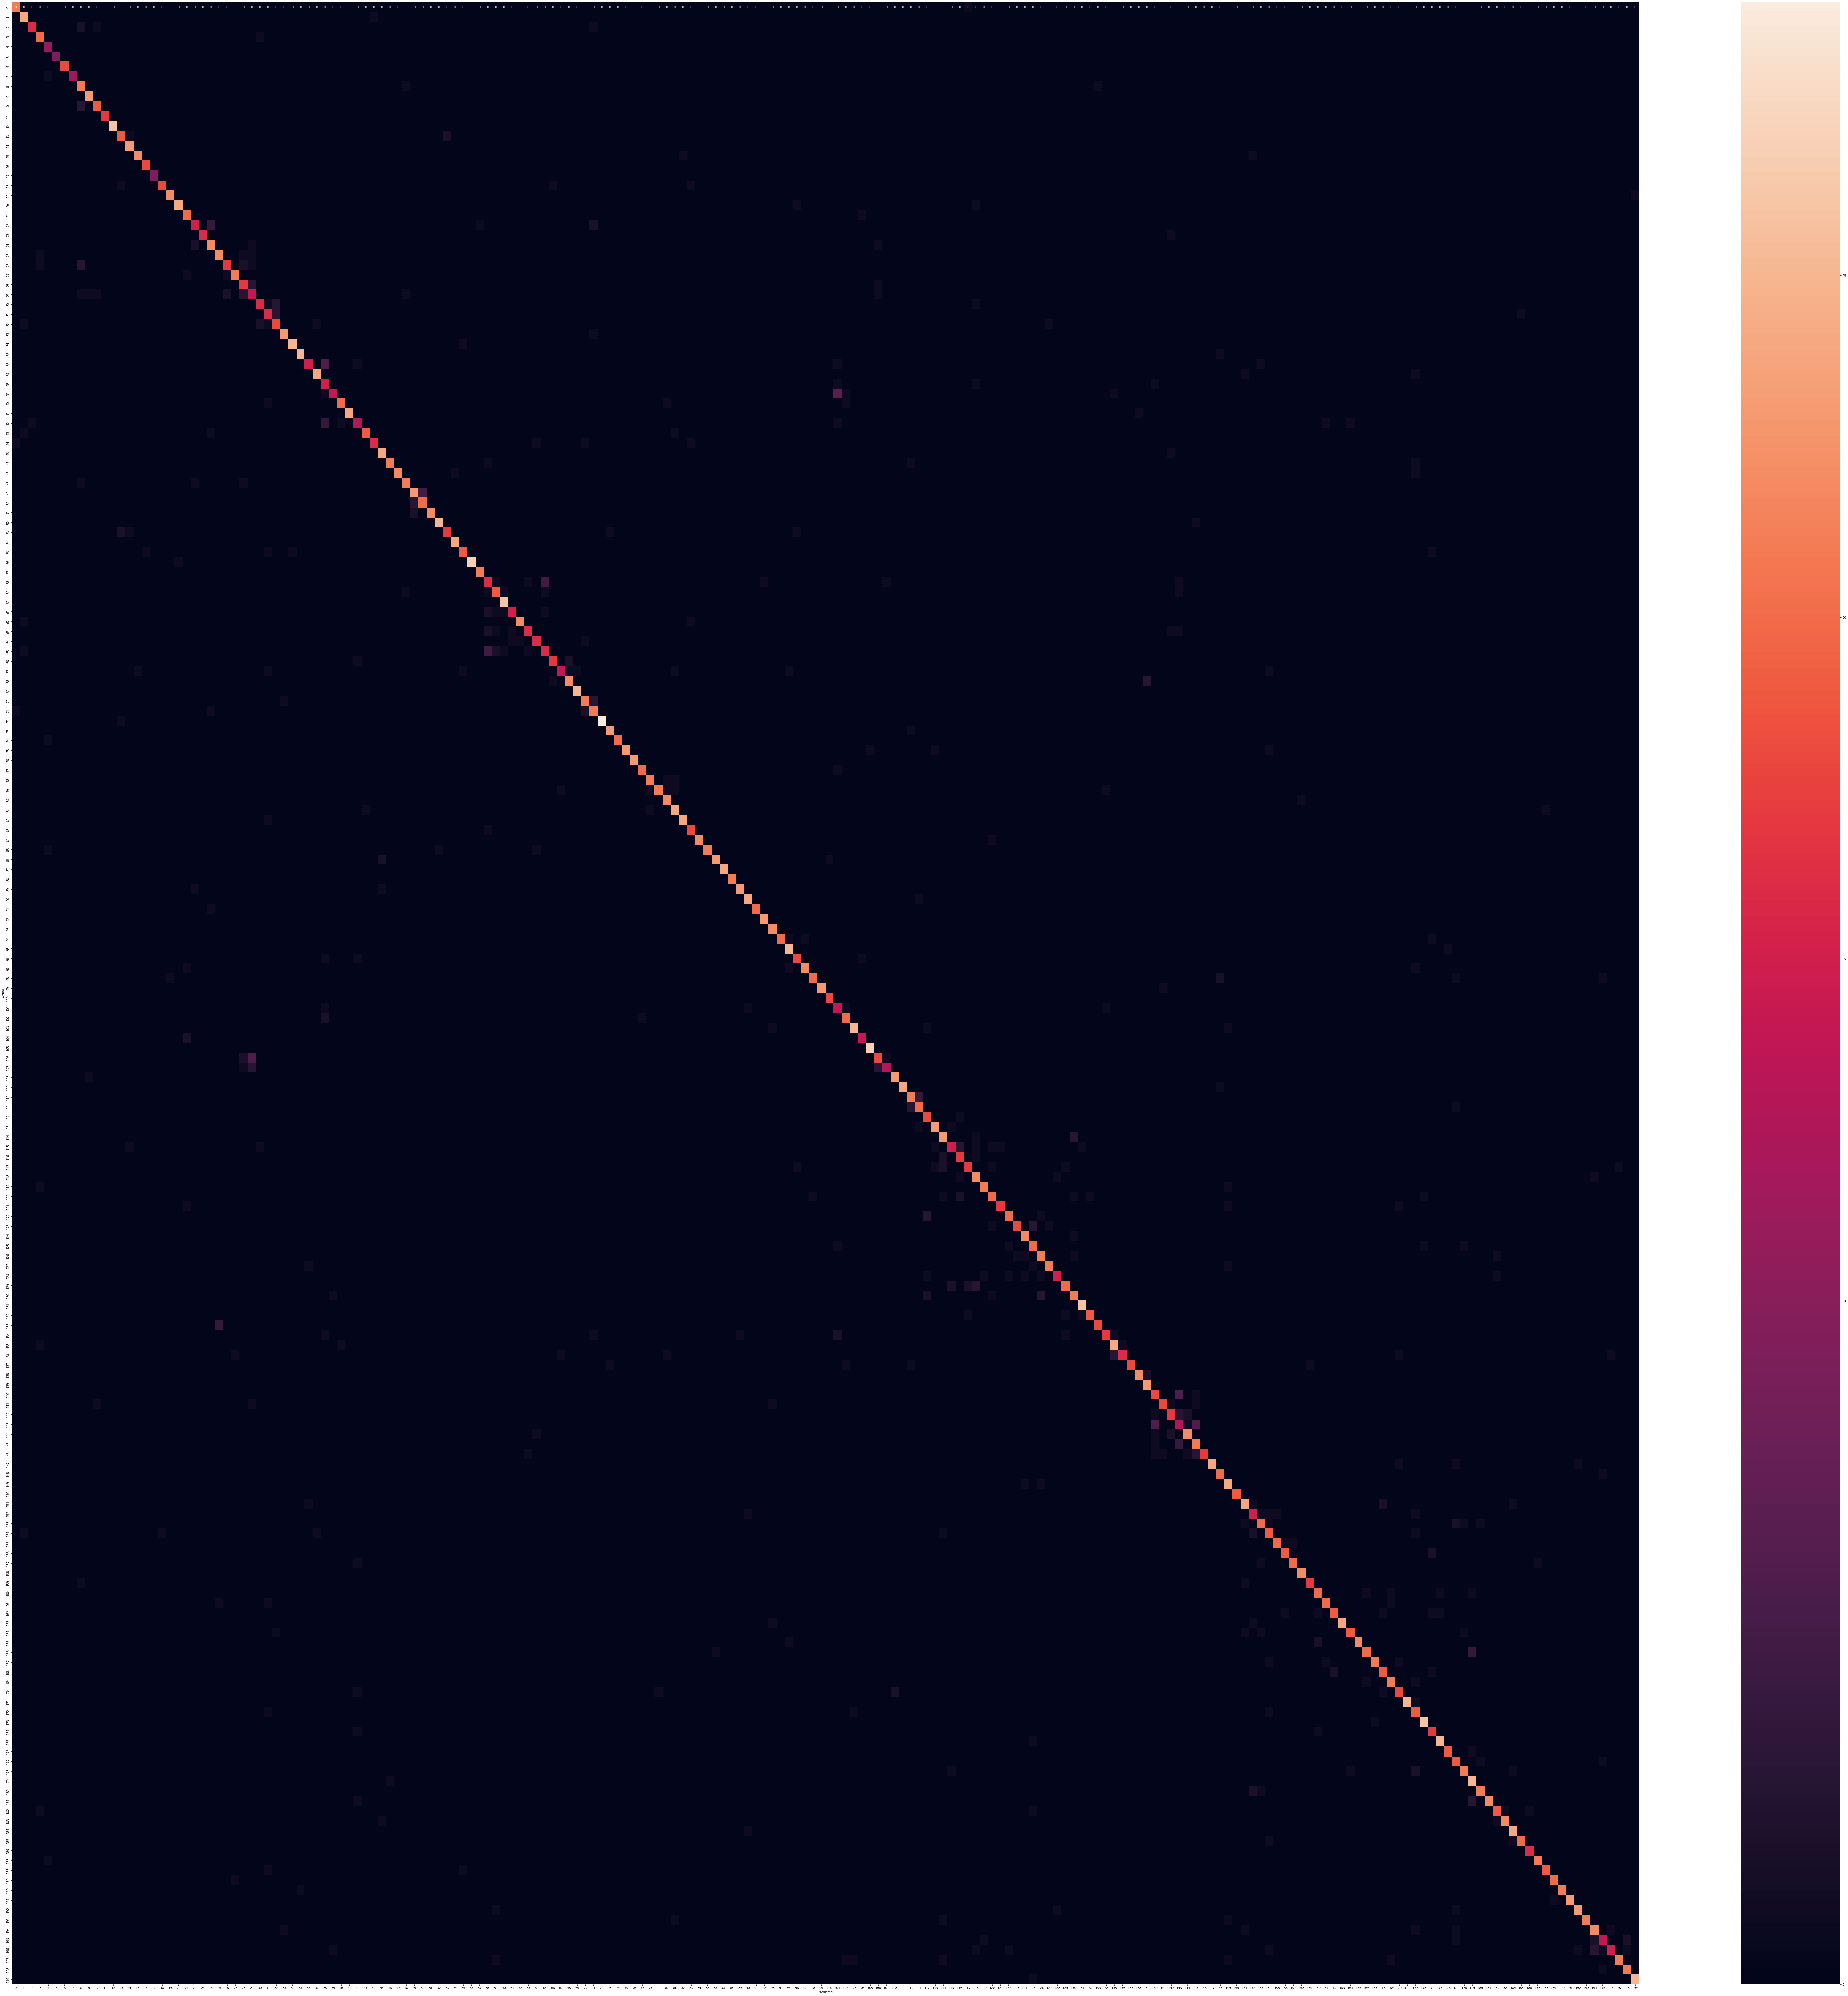

Generating classification report for model 3...


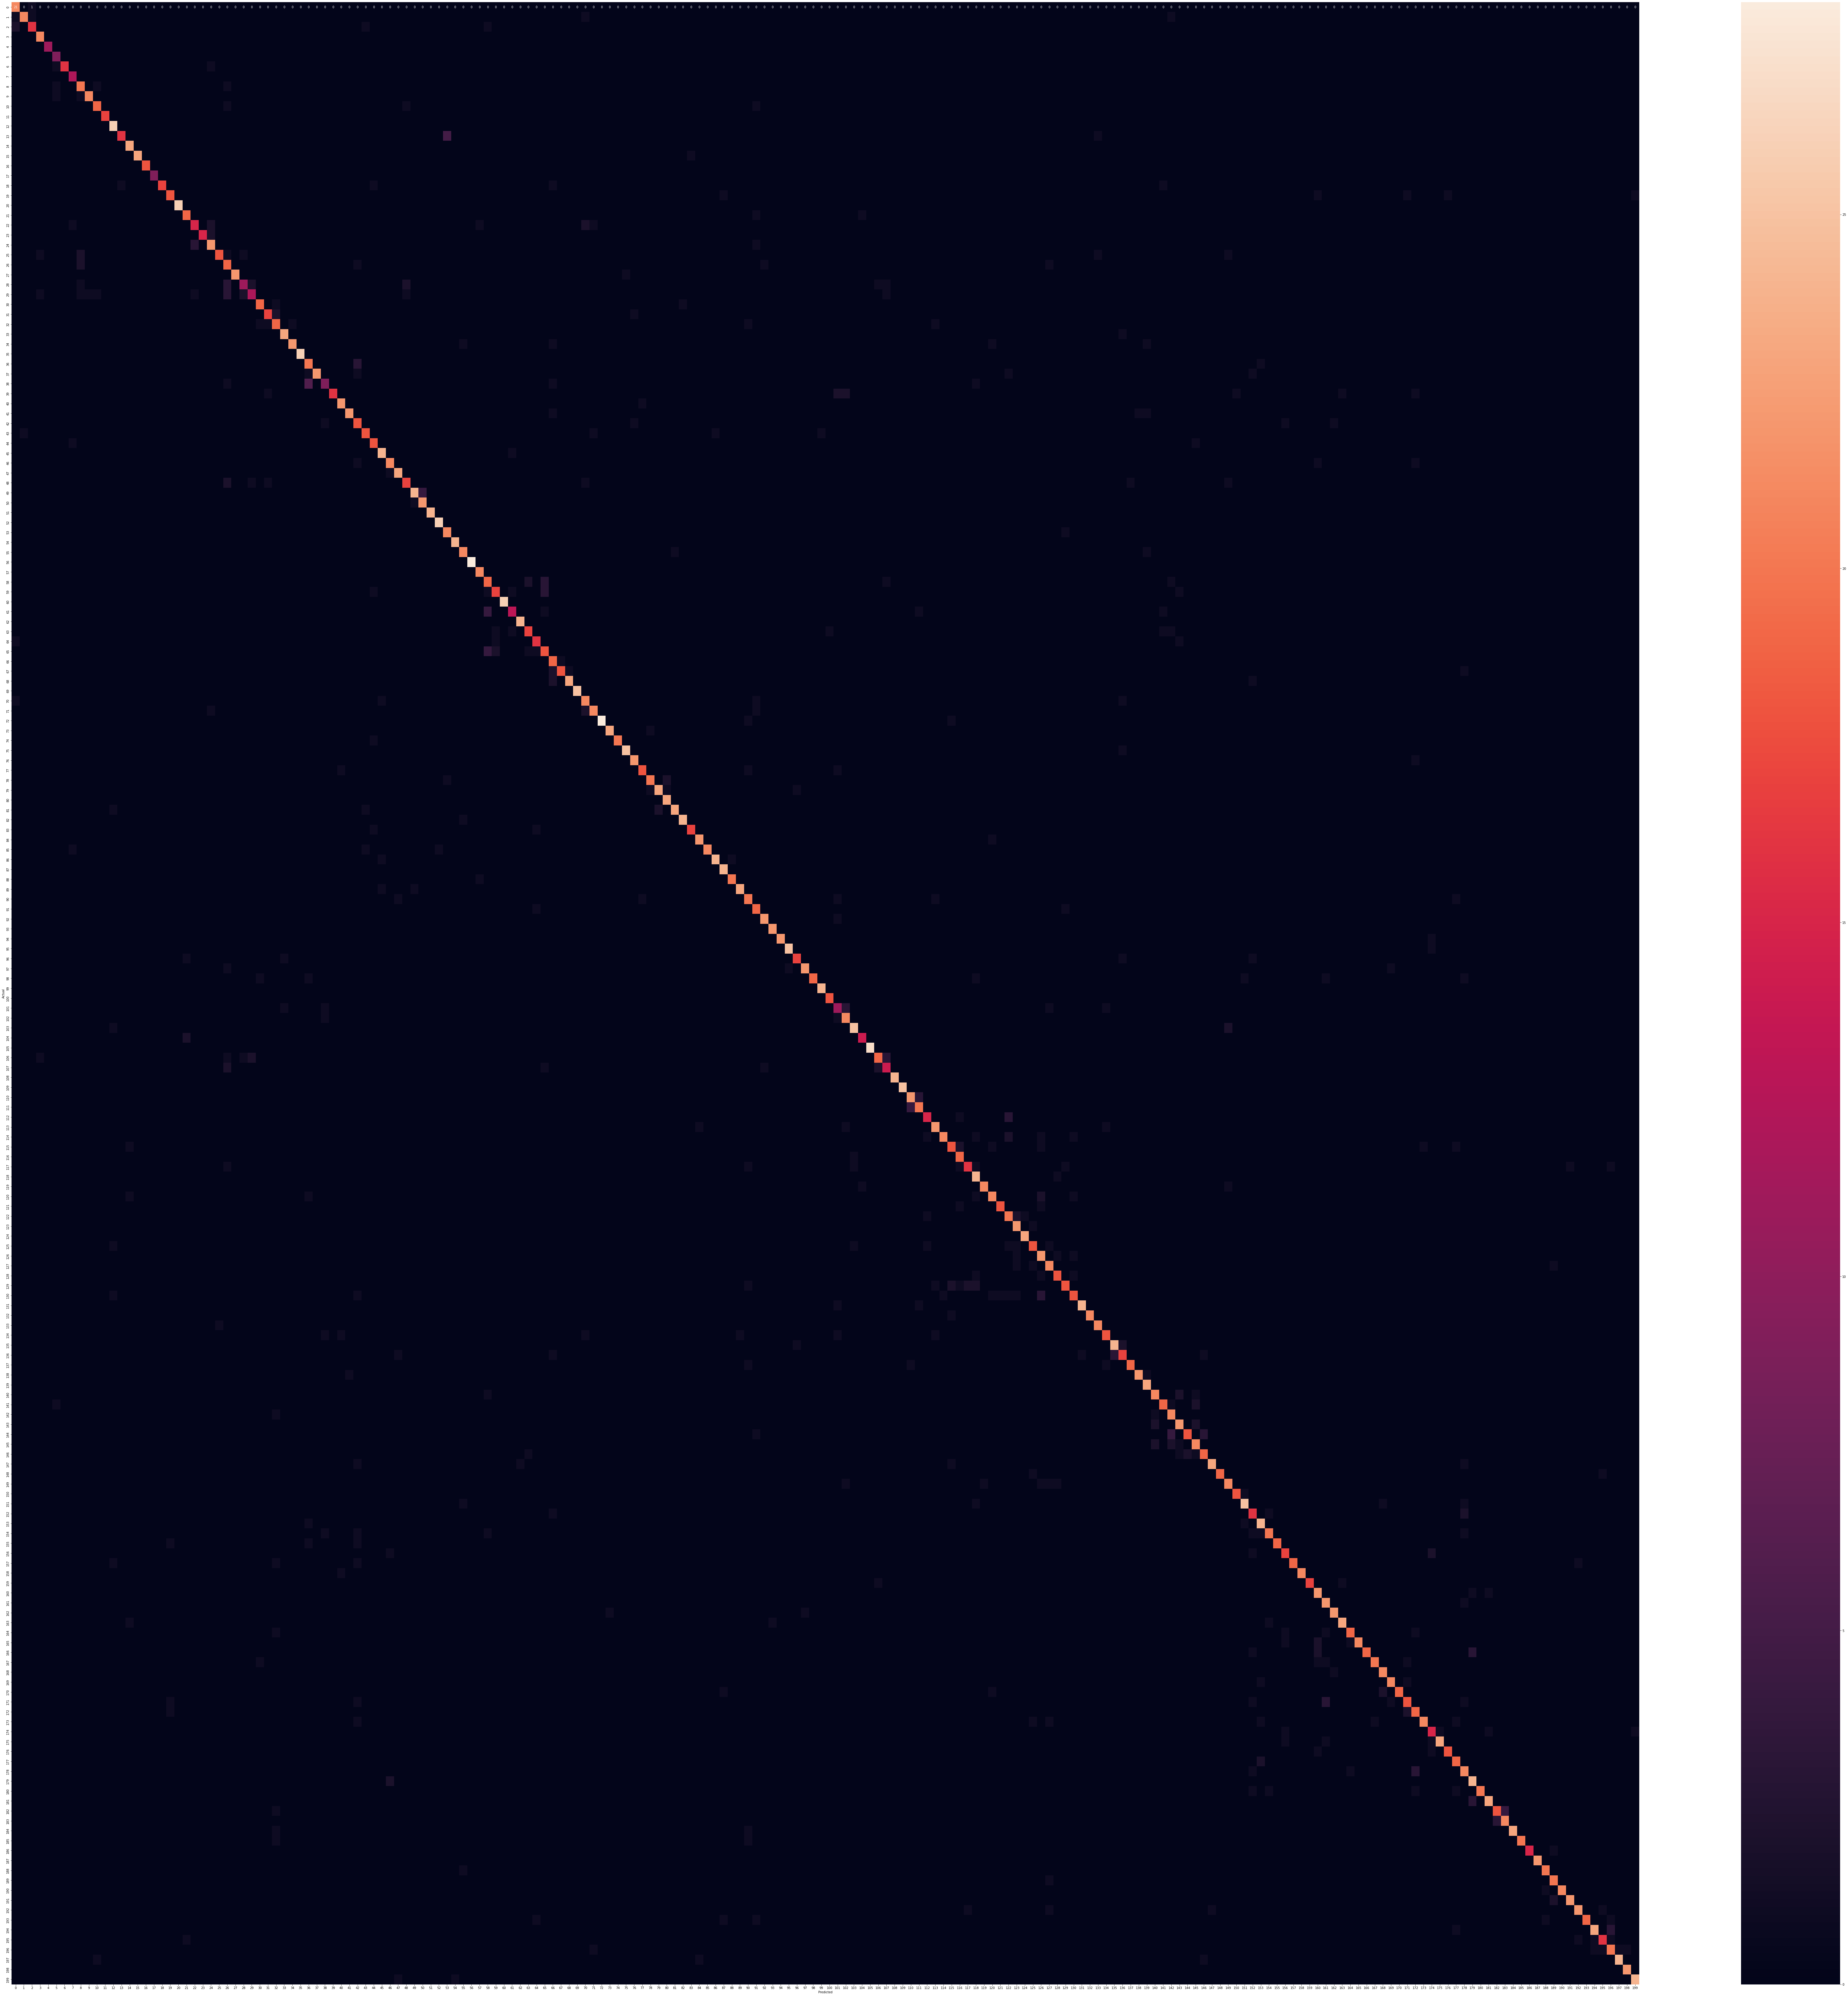

                                       precision    recall  f1-score  support
Model 1 027.Shiny_Cowbird               0.739130  0.708333  0.723404     24.0
        029.American_Crow               0.652174  0.714286  0.681818     21.0
        030.Fish_Crow                   0.652174  0.625000  0.638298     24.0
        039.Least_Flycatcher            0.650000  0.722222  0.684211     18.0
        043.Yellow_bellied_Flycatcher   0.842105  0.727273  0.780488     22.0
...                                          ...       ...       ...      ...
Model 3 172.Nashville_Warbler           0.782609  0.692308  0.734694     26.0
        174.Palm_Warbler                0.954545  0.777778  0.857143     27.0
        175.Pine_Warbler                0.714286  0.789474  0.750000     19.0
        183.Northern_Waterthrush        0.857143  0.782609  0.818182     23.0
        194.Cactus_Wren                 1.000000  0.791667  0.883721     24.0

[99 rows x 4 columns]


In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def classification_report_model(model, test_loader, device):
    model = model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = model(images)
        _, preds = torch.max(out, dim=1)
        y_true += labels.tolist()
        y_pred += preds.tolist()
    report = classification_report(y_true, y_pred, target_names=combined_dataset.classes, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(120, 120))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return pd.DataFrame(report).transpose()

# Get classification reports for each model
print("Generating classification report for model 1...")
report1 = classification_report_model(model1, test_loader, device)
print("Generating classification report for model 2...")
report2 = classification_report_model(model2, test_loader, device)
print("Generating classification report for model 3...")
report3 = classification_report_model(model3, test_loader, device)

# Find the classes with the lowest recall and precision for each model
low_recall_precision1 = report1[report1['recall'] < 0.8]
low_recall_precision2 = report2[report2['recall'] < 0.8]
low_recall_precision3 = report3[report3['recall'] < 0.8]

# Compare the models
comparison = pd.concat([low_recall_precision1, low_recall_precision2, low_recall_precision3], keys=['Model 1', 'Model 2', 'Model 3'])
print(comparison)

In [17]:
# Get the classes with the lowest recall for each model
low_recall1 = report1[report1['f1-score'] < 0.8]
low_recall2 = report2[report2['f1-score'] < 0.8]
low_recall3 = report3[report3['f1-score'] < 0.8]

# Create a table for each model
table1 = low_recall1[['f1-score']].join(report2[['f1-score']], rsuffix='_model2').join(report3[['f1-score']], rsuffix='_model3')
table2 = low_recall2[['f1-score']].join(report1[['f1-score']], rsuffix='_model1').join(report3[['f1-score']], rsuffix='_model3')
table3 = low_recall3[['f1-score']].join(report1[['f1-score']], rsuffix='_model1').join(report2[['f1-score']], rsuffix='_model2')

# Print the tables
print("Table 1:")
print(table1)
print("\nTable 2:")
print(table2)
print("\nTable 3:")
print(table3)

Table 1:
                               f1-score  f1-score_model2  f1-score_model3
009.Brewer_Blackbird           0.754717         0.763636         0.800000
027.Shiny_Cowbird              0.723404         0.772727         0.633333
029.American_Crow              0.681818         0.708333         0.611111
030.Fish_Crow                  0.638298         0.518519         0.585366
039.Least_Flycatcher           0.684211         0.612245         0.562500
040.Olive_sided_Flycatcher     0.763636         0.700000         0.800000
043.Yellow_bellied_Flycatcher  0.780488         0.619048         0.679245
059.California_Gull            0.693878         0.592593         0.666667
060.Glaucous_winged_Gull       0.769231         0.760000         0.755556
102.Western_Wood_Pewee         0.545455         0.608696         0.594595
107.Common_Raven               0.763636         0.705882         0.760000
116.Chipping_Sparrow           0.769231         0.681818         0.750000
118.House_Sparrow            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


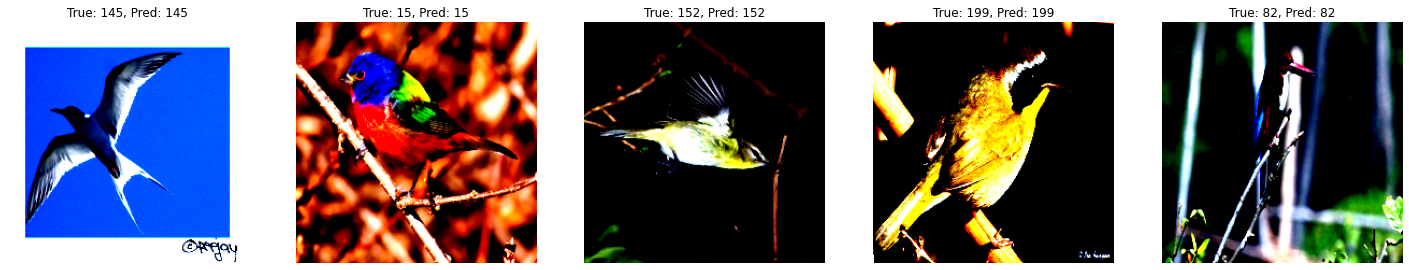

In [14]:
import matplotlib.pyplot as plt

# Get 5 random samples from the test set
samples, labels = next(iter(test_loader))
samples = samples[:5]
labels = labels[:5]

# Move to device
samples = samples.to(device)
labels = labels.to(device)

def evaluate_and_plot(model, samples, labels):
    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(samples)
        _, preds = torch.max(outputs, 1)

    # Move samples and labels back to CPU for displaying
    samples = samples.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Plot the images along with their true and predicted labels
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    for i in range(5):
        axs[i].imshow(np.transpose(samples[i], (1, 2, 0)))  # Un-normalize here if necessary
        axs[i].set_title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
        axs[i].axis('off')
    plt.show()

# Now you can call this function for each of your models
evaluate_and_plot(model1, samples, labels)
evaluate_and_plot(model2, samples, labels)
evaluate_and_plot(model3, samples, labels)